python -m jupyter kernelspec list

In [1]:
import ast
import numpy as np
import math
import matplotlib.pyplot as plt
import h5py
from patient_functions.patient import *
from patient_functions.helpers import *
from patient_functions.plotting import *

In [2]:

patient_id = 'P23336'
pat = Patient(patient_id=patient_id, h5_file_path=f'results/{patient_id}/{patient_id}_9_angles.h5')
print(pat)

Initializing Patient P23336...
Patient P23336 with 9 gaze angles and ROIs: Sclera, Cornea, OpticalNerve, OpticalDisc, Chamber, CiliaryBody, Iris, Lens, Macula, Retina, VitreousBody


Calculating all gaze angle combinations...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%  (9/9)


NameError: name 'weights' is not defined

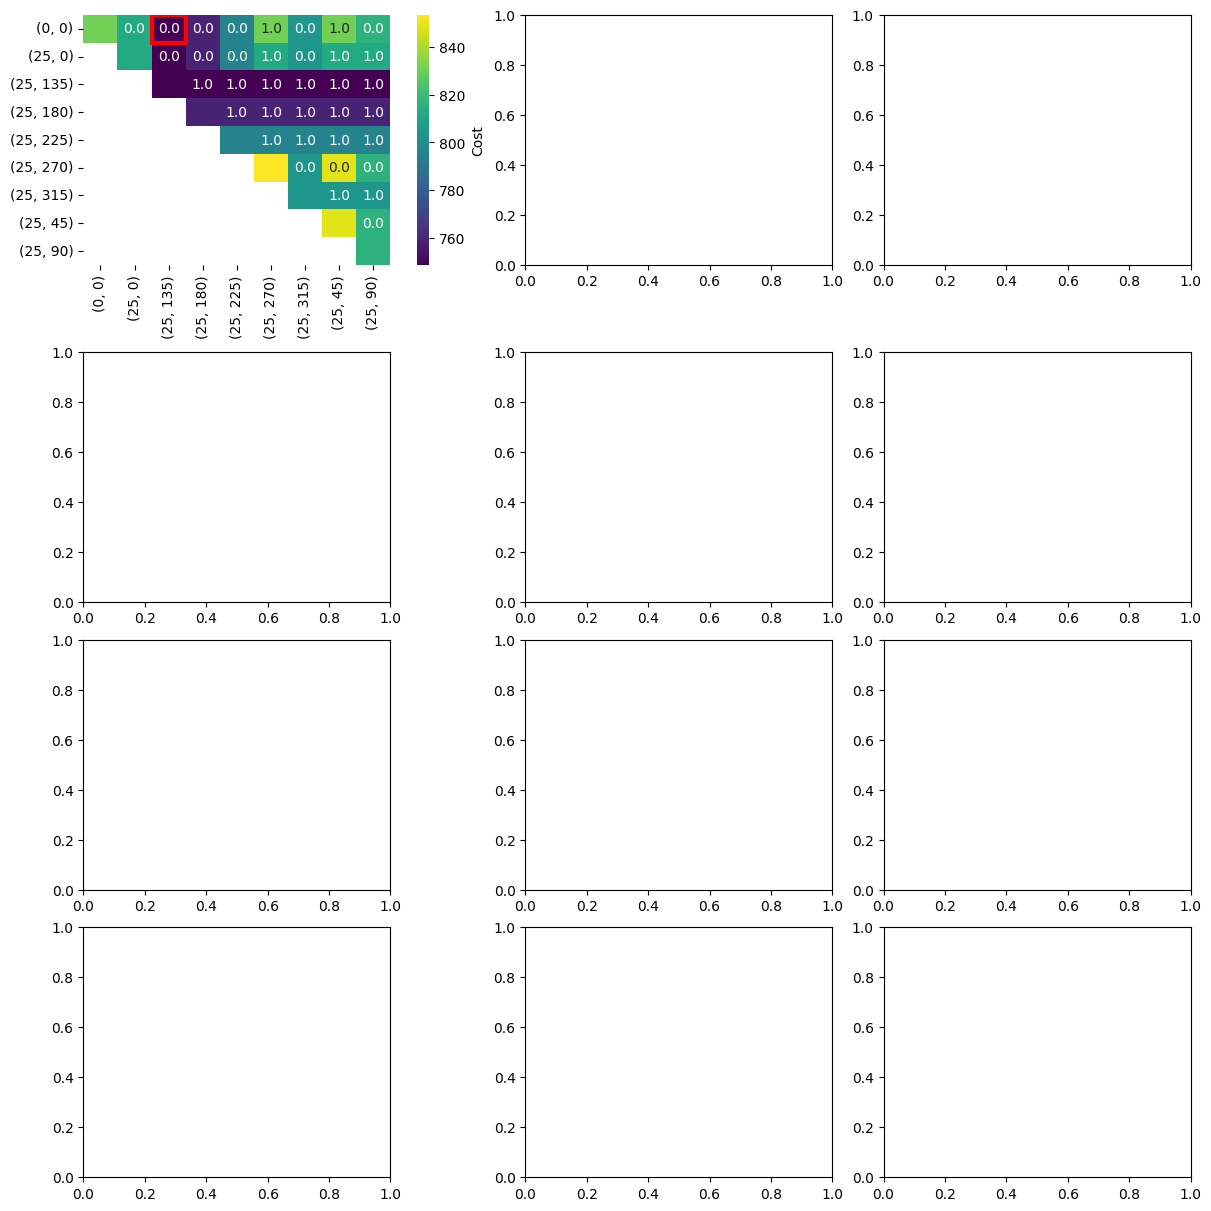

In [3]:
plot_all_gaze_combos(pat)

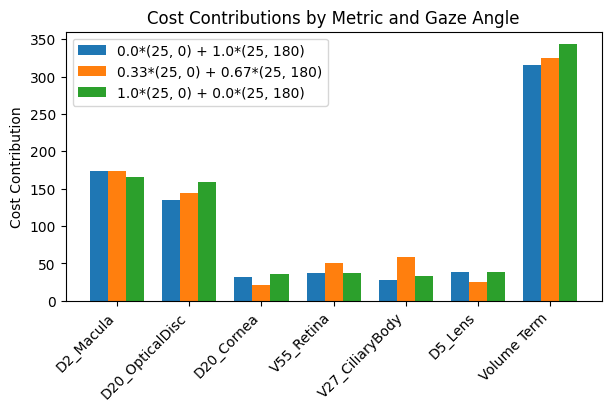

In [ ]:
compare_contributions([plans[0], plans[33],plans[-1]])

In [ ]:
with h5py.File(pat.h5py_file_path, 'r') as h5_file:
    ws = np.linspace(0, 1, 11)
    gs = []
    for i, angle_1 in enumerate(pat.gaze_angle_keys):
        dose_1 = h5_file[angle_1][:]
        for angle_2 in pat.gaze_angle_keys[i+1:]:
            dose_2 = h5_file[angle_2][:]
            for w in ws:
                g = GazeAngleDVHs(
                        patient = pat,
                        angle_key=angle_1,
                        angle_key_2=angle_2,
                        dose=w*dose_1 + (1-w)*dose_2,
                        weight=w,
                        )
                g.calculate_cost()
                gs.append(g)

AttributeError: 'Patient' object has no attribute 'h5py_file_path'

In [ ]:
def filter_gaze_angle_dvhs(dvhs, roi, vol, max_dose):
    return [dvh for dvh in dvhs if dvh.roi_dvhs[roi].get_dose_at_volume(vol) < max_dose]

In [ ]:
k = '(25.0_0.0)'
float(k.split('_')[1][:-1])

0.0

In [ ]:
roi = 'Retina'

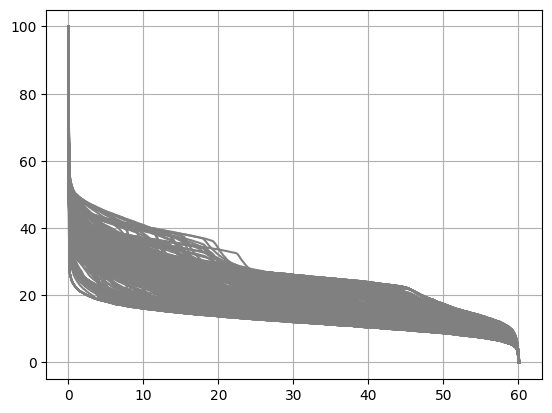

In [ ]:
fig, ax = plt.subplots()
for g in gs:
    
    g.roi_dvhs[roi].plot(ax, plot_args={'color': 'grey'})
    ax.grid(True)

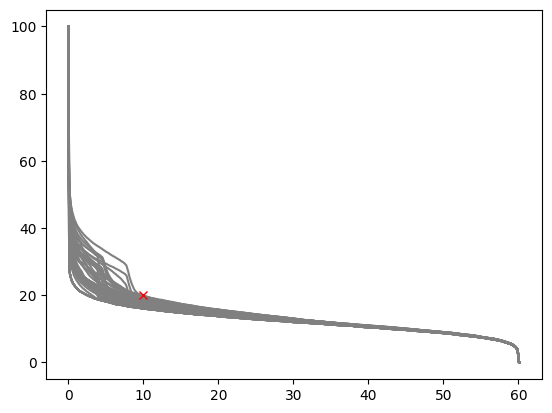

In [ ]:

vol = 20
max_dose = 10
filtered_gs = filter_gaze_angle_dvhs(
    dvhs=gs,
    roi=roi,
    vol=vol,
    max_dose=max_dose,
)

fig, ax = plt.subplots()
for g in filtered_gs:
    plt.grid()
    g.roi_dvhs[roi].plot(ax, plot_args={'color': 'grey'})
ax.plot(max_dose, vol, 'x', color='red');

In [ ]:
class Metric:
    def __init__(self, metric_str): #D20_Macula
        self.name = metric_str
        what, self.roi = metric_str.split('_')  #split into D20 and Macula
        self.metric_type = what[0]  #D
        self.value = int(what[1:])  #20

class Weight:
    def __init__(self, metric: Metric, weight: float):
        self.metric = metric
        self.weight = weight
    
    def __str__(self):
        return f'{self.metric.name}: {self.weight}'

class Weights:
    def __init__(self, weights_dict):
        self.weights = [Weight(Metric(metric_str), weight) for metric_str, weight in weights_dict.items()]
    
    def __str__(self):
        return ', '.join([f'{weight.metric.name}: {weight.weight}' for weight in self.weights])
    
    def __iter__(self):
        return iter(self.weights)
    
    def __len__(self):
        return len(self.weights)
    
    def __getitem__(self, index):
        return self.weights[index]

class Filter:
    def __init__(self, metric_str, max_value): #{'D90_Macula': 40}
        """
        Defines a filter where the specified metric must be less than max_value.
        metric_str: str, e.g. 'D90_Macula'
        max_value: float, e.g. 40
        """
        self.metric = Metric(metric_str)
        self.max_value = max_value
    
    def __str__(self):
        return f'{self.metric.name} < {self.max_value}'

class Filters:
    def __init__(self, filter_dict):
        """
        Defines multiple filters.
        filter_dict: dict, e.g. {'D90_Macula': 40, 'D20_Retina': 15}
        """
        self.filters = [Filter(metric_str, max_value) for metric_str, max_value in filter_dict.items()]
    
    def __str__(self):
        return ', '.join([f'{filter.metric.name} < {filter.max_value}' for filter in self.filters])
    
    def __iter__(self):
        return iter(self.filters)
    
    def __len__(self):
        return len(self.filters)
    
    def __getitem__(self, index):
        return self.filters[index]
    


In [ ]:
filters = Filters({'D90_Macula': 40, 'D20_Retina': 15})

In [ ]:
for f in filters:
    print(f)

D90_Macula < 40
D20_Retina < 15


In [ ]:
pat.gaze_angle_keys[1]
angle_1 = '(0, 0)'
angle_2 = '(25, 0)'

In [ ]:
pat.two_beams(gaze_angle_keys=(angle_1, angle_2), weight=0.5)

TypeError: 'bool' object is not callable

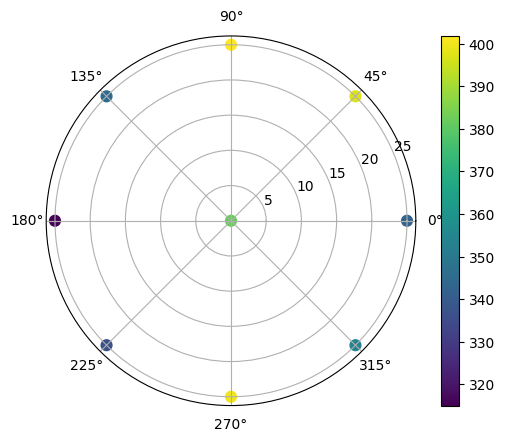

In [ ]:
metric = 'volume_term'

#metric=convert_metric(metric)
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
sc = pat.single_gaze_plot(ax, metric)
plt.colorbar(sc, ax=ax, fraction=0.05)
plt.show()


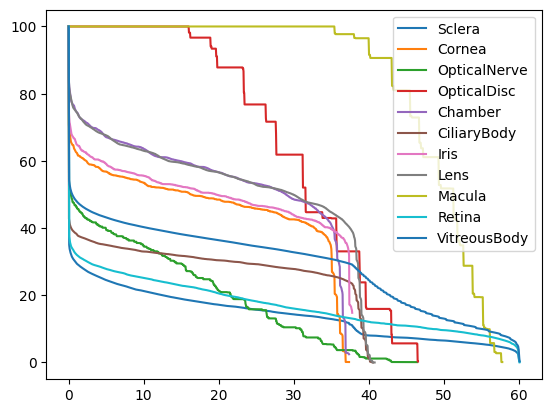

In [ ]:
fig, ax = plt.subplots()
for roi in pat.roi_names:

    pat.gaze_angle_dvhs['(0, 0)'].roi_dvhs[roi].plot(ax, {'label': roi})

plt.legend()

    

In [ ]:
pat.gaze_angle_dvhs['(0, 0)'].roi_dvhs['Macula'].get_dvh_auc()/100

In [ ]:
pat.roi_names

In [ ]:
filters = [
    {'roi_name': 'Macula', 'filter_type': 'D', 'value': 90, 'max_val': 40},
    {'roi_name': 'Lens', 'filter_type': 'V', 'value': 10, 'max_val': 1}
    ]

In [ ]:
filtered_gaze_angles=pat.apply_dvh_filters(filters)
print(filtered_gaze_angles)

In [ ]:
for roi_name in pat.roi_names:
    fig, ax = plt.subplots()
    for angle in pat.gaze_angle_keys:
        if angle not in filtered_gaze_angles:
            pat.gaze_angle_dvhs[angle].roi_dvhs[roi_name].plot(ax=ax, plot_args = {'color': 'gray'})
        else:
            pat.gaze_angle_dvhs[angle].roi_dvhs[roi_name].plot(ax=ax)
        plt.grid()
        plt.title(roi_name)